In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import krippendorff
from irrCAC.raw import CAC

import nltk
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

nltk.download('punkt')
# !python3 -m spacy download en

[nltk_data] Downloading package punkt to /Users/marcus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
grey = (187/255, 187/255, 187/255)
darkgreen = (51/255, 117/255, 56/255)
teal = (93/255, 168/255, 153/255)
blue = (148/255, 203/255, 236/255)
yellow = (220/255, 205/255, 125/255)

color_pallete = sns.color_palette([grey, darkgreen, teal, blue, yellow])

# Feedback Analysis

In [3]:
feedback_df = pd.read_csv('../Menagerie/data/grades.csv', index_col=0)
feedback_df = feedback_df[~feedback_df['grade'].isnull()]
feedback_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-
...,...,...,...,...,...,...
15,58.0,NaN,Documentation,14,1,A++
16,353.0,NaN,Documentation,14,1,A++
17,422.0,NaN,Documentation,14,1,A++
18,480.0,NaN,Documentation,14,1,A++


## Multiple Graders

In [4]:
def map_participant_group(participant_id):
    if participant_id <= 4:
        return "1-4"
    elif 4 < participant_id <= 8:
        return "5-8"
    elif 8 < participant_id <= 12:
        return "9-12"
    elif 12 < participant_id <= 16:
        return "13-16"
    elif 16 < participant_id <= 20:
        return "17-20"
    elif 20 < participant_id <= 24:
        return "21-24"
    elif 24 < participant_id <= 28:
        return "25-28"

feedback_df['group'] = feedback_df['participant_id'].apply(map_participant_group)
feedback_df['group'] = pd.Categorical(feedback_df['group'], categories=['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])
feedback_df = feedback_df.sort_values('group', ascending=True)
feedback_df.to_csv('../data/inter_rater.csv')
feedback_df

,assignment_number,comments,skill,participant_id,batch,grade,group
0,302.0,The code demonstrates a high level of organisa...,Readability,3,2,A++,1-4
4,188.0,Some method names are misleading,Readability,2,2,B,1-4
3,542.0,NaN,Readability,2,2,A-,1-4
2,277.0,NaN,Readability,2,2,A-,1-4
1,303.0,NaN,Readability,2,2,A-,1-4
...,...,...,...,...,...,...,...
3,176.0,NaN,Readability,26,1,A++,25-28
4,619.0,NaN,Readability,26,1,A-,25-28
5,305.0,NaN,Readability,26,1,A+,25-28
5,305.0,The submission includes a large number of clas...,Documentation,28,1,A++,25-28


### Length

In [5]:
feedback_df['comments'] = feedback_df['comments'].fillna("No comment supplied")
feedback_df['length'] = feedback_df['comments'].apply(len)
feedback_df

,assignment_number,comments,skill,participant_id,batch,grade,group,length
0,302.0,The code demonstrates a high level of organisa...,Readability,3,2,A++,1-4,108
4,188.0,Some method names are misleading,Readability,2,2,B,1-4,32
3,542.0,No comment supplied,Readability,2,2,A-,1-4,19
2,277.0,No comment supplied,Readability,2,2,A-,1-4,19
1,303.0,No comment supplied,Readability,2,2,A-,1-4,19
...,...,...,...,...,...,...,...,...
3,176.0,No comment supplied,Readability,26,1,A++,25-28,19
4,619.0,No comment supplied,Readability,26,1,A-,25-28,19
5,305.0,No comment supplied,Readability,26,1,A+,25-28,19
5,305.0,The submission includes a large number of clas...,Documentation,28,1,A++,25-28,211


/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_87728/1045416803.py:1: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  length_plt = sns.boxplot(feedback_df[feedback_df['length'] < 550], x='group', y='length', hue='skill', dodge=True, palette=color_pallete, hue_order=['Correctness', 'Code Elegance', 'Readability', 'Documentation'])


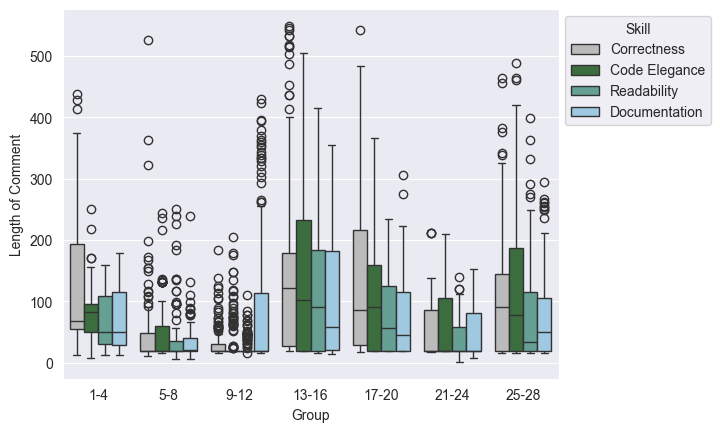

In [6]:
length_plt = sns.boxplot(feedback_df[feedback_df['length'] < 550], x='group', y='length', hue='skill', dodge=True, palette=color_pallete, hue_order=['Correctness', 'Code Elegance', 'Readability', 'Documentation'])
length_plt.set(xlabel='Group', ylabel='Length of Comment')
sns.move_legend(length_plt, "upper left", bbox_to_anchor=(1, 1), title='Skill')
length_plt.get_figure().savefig('plots/inter_rater_length.pdf', bbox_inches='tight')

### Comment Similarity
- To clarify: does taking the mean cosine sim of each assignment and then plotting it make sense?

In [7]:
inter_rater_sim_df = pd.read_csv('../data/inter_rater_sim.csv')
inter_rater_sim_df = inter_rater_sim_df[~((inter_rater_sim_df['feedback_1'] == 'No comment supplied' ) & (inter_rater_sim_df['feedback_2'] == 'No comment supplied'))]
inter_rater_sim_df = inter_rater_sim_df[['group', 'assignment_number', 'skill', 'sim']].groupby(['group', 'assignment_number', 'skill']).mean().reset_index()
inter_rater_sim_df.head(20)

,group,assignment_number,skill,sim
0,1-4,29.0,Code Elegance,0.290893
1,1-4,29.0,Correctness,0.346559
2,1-4,29.0,Documentation,0.270871
3,1-4,29.0,Readability,0.270871
4,1-4,36.0,Code Elegance,0.380823
5,1-4,36.0,Correctness,0.547184
6,1-4,36.0,Documentation,0.398740
7,1-4,36.0,Readability,0.484722
8,1-4,59.0,Code Elegance,0.363281
9,1-4,59.0,Correctness,0.445805


/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_87728/3732208777.py:1: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  g = sns.boxplot(inter_rater_sim_df, x='group', y='sim', hue='skill', palette=color_pallete, hue_order=['Correctness', 'Code Elegance', 'Readability', 'Documentation'])


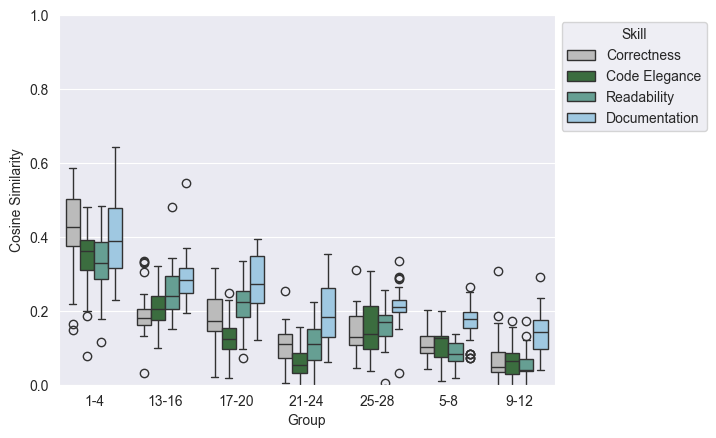

In [8]:
g = sns.boxplot(inter_rater_sim_df, x='group', y='sim', hue='skill', palette=color_pallete, hue_order=['Correctness', 'Code Elegance', 'Readability', 'Documentation'])
g.set(xlabel='Group', ylabel='Cosine Similarity', ylim=(0,1))
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1), title='Skill')
g.get_figure().savefig('plots/inter_rater_sim.pdf', bbox_inches='tight')

## Dominant Topic
- Use nominal Krippendorf's and Gwet's AC1

In [9]:
correctness_dominant_df = pd.read_csv('../data/dominant_topics_correctness.csv')
correctness_dominant_df['skill'] = 'Correctness'

ce_dominant_df = pd.read_csv('../data/dominant_topics_code_elegance.csv')
ce_dominant_df['skill'] = 'Code Elegance'

read_dominant_df = pd.read_csv('../data/dominant_topics_readability.csv')
read_dominant_df['skill'] = 'Readability'

doc_dominant_df = pd.read_csv('../data/dominant_topics_documentation.csv')
doc_dominant_df['skill'] = 'Documentation'

dominant_df = pd.concat([correctness_dominant_df, ce_dominant_df, read_dominant_df, doc_dominant_df])

dominant_df = dominant_df[dominant_df['assignment_number'] != 105]

dominant_df['skill'].value_counts()

skill
Correctness      710
Documentation    707
Code Elegance    674
Readability      628
Name: count, dtype: int64

In [10]:
dominant_df['group'] = dominant_df['participant_id'].apply(map_participant_group)
dominant_df['group'] = pd.Categorical(dominant_df['group'], categories=['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])
dominant_df = dominant_df.sort_values('group', ascending=True)
dominant_df['Dominant_Topic'] = pd.Categorical(dominant_df['Dominant_Topic'])

# dominant_df = dominant_df[dominant_df['group'] != '9-12']
dominant_df.head()

,assignment_number,comments,participant_id,batch,processed_text,Dominant_Topic,Perc_Contribution,Topic_Keywords,All_Topics,skill,group
652,601.0,Code could make use of abstract classes to imp...,2,1,"['code', 'class', 'extensibility', 'breakdown']",Design,0.666557,"design, variable, implementation, extensibilit...","[('Design', 0.6665572), ('Inheritance', 0.1667...",Code Elegance,1-4
626,234.0,Good readability.,1,1,[],Structure,0.250000,"function, structure, indentation, level, varia...","[('Structure', 0.25), ('Indentation', 0.25), (...",Readability,1-4
625,601.0,Generally good readability.,1,1,[],Structure,0.250000,"function, structure, indentation, level, varia...","[('Structure', 0.25), ('Indentation', 0.25), (...",Readability,1-4
624,629.0,Some unconvential shorthands are used for some...,1,1,"['shorthand', 'variable']",Access Modifier,0.624990,"variable, method, modifier, access, indentatio...","[('Access Modifier', 0.62498987), ('Indentatio...",Readability,1-4
623,588.0,Inconsistent casing where unnecessary. General...,1,1,['casing'],Structure,0.250000,"function, structure, indentation, level, varia...","[('Structure', 0.25), ('Indentation', 0.25), (...",Readability,1-4


In [11]:
dominant_df['Dominant_Topic'].unique()

['Design', 'Structure', 'Access Modifier', 'Naming', 'Quality', ..., 'Abstraction', 'Inheritance', 'Extension Tasks', 'Structure/Style', 'Relevance']
Length: 13
Categories (13, object): ['Abstraction', 'Access Modifier', 'Code/Compilation', 'Core Tasks', ..., 'Quality', 'Relevance', 'Structure', 'Structure/Style']

In [12]:
# Topics are norminal

def calculate_krippendorrf_alpha(skill, group):
    skill_df = dominant_df[dominant_df['skill'] == skill][['participant_id', 'assignment_number', 'group', 'Dominant_Topic']].copy()
    group_df = skill_df[skill_df['group'] == group].sort_values(by='participant_id')

    group_df['Dominant_Topic'] = group_df['Dominant_Topic'].cat.codes
    
    pivot = group_df.pivot(columns='assignment_number', index='participant_id', values='Dominant_Topic')

    return krippendorff.alpha(pivot.to_numpy(), level_of_measurement='nominal')

In [13]:
calculate_krippendorrf_alpha('Code Elegance', '13-16')

-0.1425274091171378

In [14]:
def calculate_ac1(skill, group):
    skill_df = dominant_df[dominant_df['skill'] == skill][['participant_id', 'assignment_number', 'group', 'Dominant_Topic']].copy()
    group_df = skill_df[skill_df['group'] == group].sort_values(by='participant_id')

    group_df['Dominant_Topic'] = group_df['Dominant_Topic'].cat.codes
    # Transpose pivot to get in form required by library rater by assignment
    pivot = group_df.pivot(columns='assignment_number', index='participant_id', values='Dominant_Topic').T
    cac = CAC(pivot)

    return cac.gwet()['est']['coefficient_value']

In [15]:
calculate_ac1('Correctness', '13-16')

0.02297

In [16]:
def calculate_all_reliability_metric(metric):
    results_df = None

    for skill in ['Correctness', 'Readability', 'Code Elegance', 'Documentation']:
        for group in dominant_df['group'].unique():
            try:
                if metric == 'krippendorff':
                    metric_result = calculate_krippendorrf_alpha(skill, group)
                else:
                    metric_result = calculate_ac1(skill, group)
                
            except ValueError as e:
                print('Error duplicate entries check data for: ', group, 'error: ', e)
                metric_result = np.nan

            results_df = pd.concat([results_df, pd.DataFrame({
                'group': group,
                'skill': skill,
                'metric_result': metric_result}, index=[0])])

            results_df['group'] = pd.Categorical(results_df['group'], ['1-4', '5-8', '9-12', '13-16', '17-20', '21-24', '25-28'])

    return results_df

In [17]:
alpha_df = calculate_all_reliability_metric('krippendorff').sort_values(by='group')
alpha_df.head()

Error duplicate entries check data for:  9-12 error:  There has to be at least one unit with values assigned by at least two coders.
Error duplicate entries check data for:  9-12 error:  There has to be at least one unit with values assigned by at least two coders.


,group,skill,metric_result
0,1-4,Correctness,-0.091630
0,1-4,Documentation,-0.063031
0,1-4,Code Elegance,0.028774
0,1-4,Readability,-0.158970
0,5-8,Correctness,-0.087613


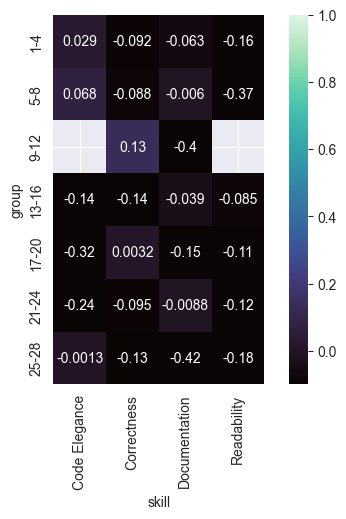

In [18]:
# Errors thrown here as 9-12 only has one rater in two topics

pivot_df = alpha_df.pivot(index='group', columns='skill', values='metric_result')#.transpose()
g = sns.heatmap(pivot_df, annot=True, cmap=sns.color_palette("mako", as_cmap=True), square=True, vmin=-0.1, vmax=1)
g.get_figure().savefig('plots/krippendorrf.pdf', bbox_inches='tight')

In [19]:
# Errors thrown here as 9-12 only has one rater in two topics

ac1_df = calculate_all_reliability_metric('ac1').sort_values(by='group')
ac1_df.head()

/Users/marcus/workspace/Programming/Consistency_In_Grading_Analysis/venv3.10/lib/python3.10/site-packages/irrCAC/raw.py:246: RuntimeWarning: invalid value encountered in scalar divide
  pa = sum(sum_q[ri_vec >= 2] / (ri_vec * (ri_vec - 1))[ri_vec >= 2]) / n2more
/Users/marcus/workspace/Programming/Consistency_In_Grading_Analysis/venv3.10/lib/python3.10/site-packages/irrCAC/raw.py:261: RuntimeWarning: divide by zero encountered in scalar divide
  ac1_ivec = (self.n / n2more) * (pa_ivec - pe_r2) / (1 - pe)
/Users/marcus/workspace/Programming/Consistency_In_Grading_Analysis/venv3.10/lib/python3.10/site-packages/irrCAC/raw.py:261: RuntimeWarning: invalid value encountered in multiply
  ac1_ivec = (self.n / n2more) * (pa_ivec - pe_r2) / (1 - pe)
/Users/marcus/workspace/Programming/Consistency_In_Grading_Analysis/venv3.10/lib/python3.10/site-packages/irrCAC/raw.py:246: RuntimeWarning: invalid value encountered in scalar divide
  pa = sum(sum_q[ri_vec >= 2] / (ri_vec * (ri_vec - 1))[ri_vec >=

,group,skill,metric_result
0,1-4,Correctness,0.33818
0,1-4,Documentation,0.75897
0,1-4,Code Elegance,0.47772
0,1-4,Readability,0.19867
0,5-8,Correctness,0.75720


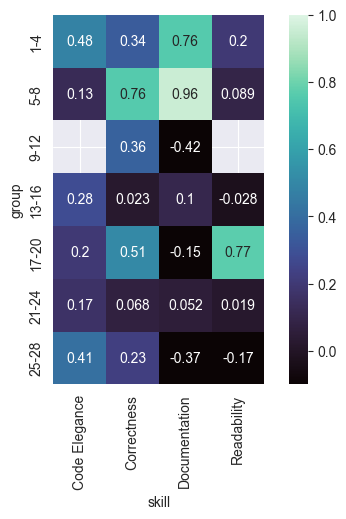

In [20]:
pivot_df = ac1_df.pivot(index='group', columns='skill', values='metric_result')#.transpose()
g = sns.heatmap(pivot_df, annot=True, cmap=sns.color_palette("mako", as_cmap=True), square=True, vmin=-0.1, vmax=1)
g.get_figure().savefig('plots/ac1.pdf', bbox_inches='tight')